In [36]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
# from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
from datetime import datetime

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
# Function for visualization of the result
def plot_predictions(test_arr, 
                     predicted_arr, 
                     y_label, 
                     title, 
                     x_label='time'):
    plt.plot(test_arr, color='red', label='Real')
    plt.plot(predicted_arr, color='blue', label='Predicted')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()


Root Mean Squared Error
Root mean squared error (RMSE) is the square root of the mean of the square of all of the error. The use of RMSE is very common, and it is considered an excellent general-purpose error metric for numerical predictions.

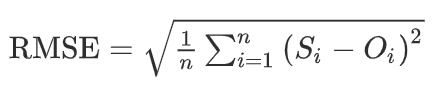

where Oi are the observations, Si predicted values of a variable, and n the number of observations available for analysis. RMSE is a good measure of accuracy, but only to compare prediction errors of different models or model configurations for a particular variable and not between variables, as it is scale-dependent.

In [39]:
def return_rmse(test, predicted):
    if len(test) != len(predicted):
        predicted = predicted[:-1]

    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root MSE = {}.".format(rmse))

In [40]:
# Read the data
dataset_FXCN = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/diploma/diploma/data/FXCN.xlsx', 
                             index_col='date',
                             parse_dates=['date'])
dataset_FXCN = dataset_FXCN.rename(columns={'value': 'value_FXCN'}, inplace=False)

dataset_FXUS = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/diploma/diploma/data/FXUS.xlsx', 
                             index_col='date',
                             parse_dates=['date'])
dataset_FXUS = dataset_FXUS.rename(columns={'value': 'value_FXUS'}, inplace=False)

dataset_FXRL = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/diploma/diploma/data/FXRL.xlsx', 
                             index_col='date',
                             parse_dates=['date'])
dataset_FXRL = dataset_FXRL.rename(columns={'value': 'value_FXRL'}, inplace=False)

dataset_FXDE = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/diploma/diploma/data/FXDE.xlsx', 
                             index_col='date',
                             parse_dates=['date'])
dataset_FXDE = dataset_FXDE.rename(columns={'value': 'value_FXDE'}, inplace=False)


# inner join tables by date
dataset = pd.concat([dataset_FXCN,
                     dataset_FXUS,
                     dataset_FXRL,
                     dataset_FXDE],
                    axis='columns', join="inner")

dataset.head()


,value_FXCN,value_FXUS,value_FXRL,value_FXDE
date,,,,
2017-12-13,42.9949,0.468924,0.328384,0.311479
2017-12-14,42.9248,0.467030,0.331954,0.310235
2017-12-15,42.4451,0.471207,0.330392,0.310918
2017-12-18,42.7756,0.473789,0.330322,0.315646
2017-12-19,43.0395,0.472255,0.326443,0.313632


In [41]:
# Checking for missing values
training_set = dataset[:'2020'].iloc[:, 0:1].values
test_set = dataset['2021':].iloc[:, 0:1].values

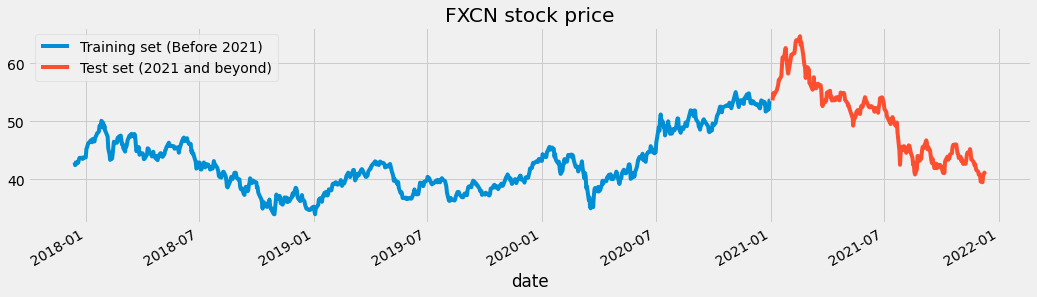

In [42]:
# Visualization of dataset
def plot_dataset(dataset, value_attribute, training_to_str, test_from_str, title):
    dataset[value_attribute][:training_to_str].plot(figsize=(16, 4), legend=True)
    dataset[value_attribute][test_from_str:].plot(figsize=(16, 4), legend=True)
    plt.legend(['Training set (Before ' + test_from_str + ')',
                'Test set (' + test_from_str + ' and beyond)'])
    plt.title(title)

    plt.show()


plot_dataset(dataset, 
             value_attribute='value_FXCN', 
             training_to_str='2020', 
             test_from_str='2021',
             title='FXCN stock price')

### class sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1), *, copy=True, clip=False)[source]
Transform features by scaling each feature to a given range.

This estimator scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.

The transformation is given by:

X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
X_scaled = X_std * (max - min) + min
where min, max = feature_range.

This transformation is often used as an alternative to zero mean, unit variance scaling.

### fit_transform(X, y=None, **fit_params)[source]¶
Fit to data, then transform it.

Fits transformer to X and y with optional parameters fit_params and returns a transformed version of X.

The fit method is calculating the mean and variance of each of the features present in our data. The transform method is transforming all the features using the respective mean and variance.

In [43]:
# Normalization scales each input variable separately to the range 0-1
sc = MinMaxScaler(feature_range=(0, 1)) # scaler initialization
training_set_scaled = sc.fit_transform(training_set) # apply scaler on training_set

# training_set_scaled.view()

In [44]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output

time_interval = 120  # So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []

for i in range(time_interval, len(training_set_scaled)):
    X_train.append(training_set_scaled[i - time_interval:i, 0])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

In [45]:
# Reshaping X_train for efficient ???
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [46]:
# The LSTM architecture

# Allows you to create models layer-by-layer for most problems. 
# It is limited in that it does not allow you to create models that share layers or have multiple inputs or outputs.
regressor = Sequential()

# First LSTM layer
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
regressor.add(Dropout(0.2))  # Dropout regularisation

# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))  # Dropout regularisation

# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))  # Dropout regularisation

# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))  # Dropout regularisation

# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop', loss='mean_squared_error')

# Fitting to the training set
regressor.fit(X_train, y_train, epochs=50, batch_size=32) #  batch_size is the number of samples per gradient update. 

Epoch 1/50
21/21 [==============================] - 13s 254ms/step - loss: 0.0350
Epoch 2/50
21/21 [==============================] - 5s 251ms/step - loss: 0.0176
Epoch 3/50
21/21 [==============================] - 5s 250ms/step - loss: 0.0143
Epoch 4/50
21/21 [==============================] - 5s 252ms/step - loss: 0.0132
Epoch 5/50
21/21 [==============================] - 5s 257ms/step - loss: 0.0123
Epoch 6/50
21/21 [==============================] - 5s 255ms/step - loss: 0.0118
Epoch 7/50
21/21 [==============================] - 5s 251ms/step - loss: 0.0115
Epoch 8/50
21/21 [==============================] - 5s 253ms/step - loss: 0.0100
Epoch 9/50
21/21 [==============================] - 5s 249ms/step - loss: 0.0117
Epoch 10/50
21/21 [==============================] - 5s 257ms/step - loss: 0.0092
Epoch 11/50
21/21 [==============================] - 5s 254ms/step - loss: 0.0076
Epoch 12/50
21/21 [==============================] - 5s 254ms/step - loss: 0.0091
Epoch 13/50
21/21 [=====

### transform()

Using the transform method we can use the same mean and variance as it is calculated from our training data to transform our test data with method transform_fit(). Thus, the parameters learned by our model using the training data will help us to transform our test data.

In [47]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'value_FXCN' attribute data for processing
dataset_total = pd.concat((dataset["value_FXCN"][:'2020'], dataset["value_FXCN"]['2021':]), axis=0)
inputs = dataset_total[len(dataset_total) - len(test_set) - time_interval:].values # input dataset to model
inputs = inputs.reshape(-1, 1)  # reshape to an array with 1 dimention

# Scale test data
inputs = sc.transform(inputs) 

In [48]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(time_interval, len(inputs) + 1):
    X_test.append(inputs[i - time_interval:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


# Apply model for prediction
predicted_stock_price = regressor.predict(X_test)
# Scale back the data to the original representation
predicted_stock_price = sc.inverse_transform(predicted_stock_price) 

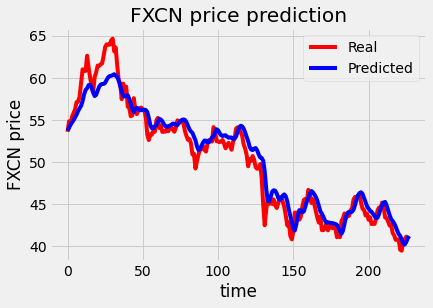

In [49]:
# Visualizing the results for LSTM
plot_predictions(test_arr=test_set,
                 predicted_arr=predicted_stock_price,
                 y_label='FXCN price',
                 title='FXCN price prediction')

In [50]:
# Evaluating our model
return_rmse(test_set, predicted_stock_price)

The root MSE = 1.5964585612226248.


Last price: 
             value_FXCN  value_FXUS  value_FXRL  value_FXDE
date                                                      
2021-12-10     40.8747    0.857985    0.558631    0.350206
Predicted price: 
             value_FXCN
date                  
2021-12-13    41.23716


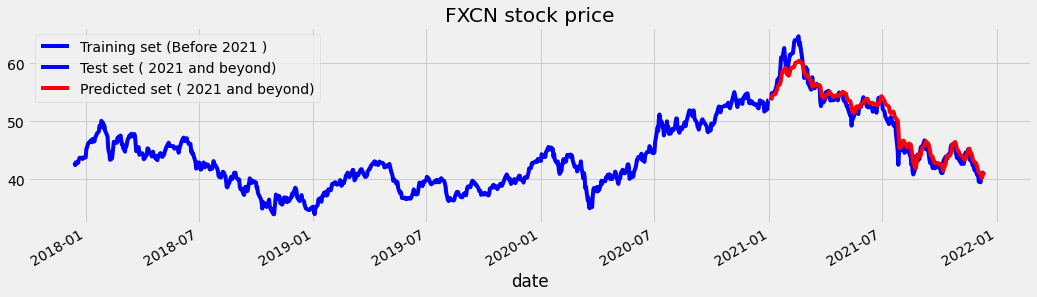

In [51]:
# Function for visualization of the result
def plot_predictions_on_whole_interval(*, predicted_array, 
                                       from_test, 
                                       to_train, 
                                       title, 
                                       date_column, 
                                       target_column):
    # Convert np.array to Dataframe
    test_dates = pd.DataFrame(dataset[from_test:].index.values, columns=[date_column]).append(pd.DataFrame({'date': [datetime.strptime('2021-12-13', '%Y-%m-%d')]}), ignore_index=True)
    test_predicted_df = pd.DataFrame(predicted_array, columns=[target_column])

    # inner join tables by date
    predicted_data = pd.concat([test_dates, test_predicted_df], 
                               axis='columns', join="inner").set_index(date_column)

    # Visualization of datasets
    dataset[target_column][:to_train].plot(figsize=(16, 4), legend=True, color='blue') # Train
    dataset[target_column][from_test:].plot(figsize=(16, 4), legend=True, color='blue') # Test
    predicted_data[target_column][from_test:].plot(figsize=(16, 4), legend=True, color='red') # Predicted
    plt.legend(['Training set (Before ' + from_test + ' )',
                'Test set ( ' + from_test + ' and beyond)',
                'Predicted set ( ' + from_test + ' and beyond)'])
    plt.title(title)
    
    print('Last price: \n', dataset.iloc[[-1]])
    print('Predicted price: \n', predicted_data.iloc[[-1]])
    plt.show()


plot_predictions_on_whole_interval(predicted_array=predicted_stock_price,
                                   from_test='2021',
                                   to_train='2020',
                                   title='FXCN stock price',
                                   date_column='date',
                                   target_column='value_FXCN')